# One Hidden Layer Tanh Model

In [1]:
import argparse
import os
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# matplotlib.use("Agg")  # noqa: E402

In [2]:
class OneLayerTanhModel(object):
    
    def __init__(
        self, 
        true_param_dict, 
        num_training_samples=10, 
        input_dim=1, 
        output_dim=1,
        num_hidden_nodes=1, 
        itemp=1.0,
        sigma=1.0
    ):
        self.true_param_dict = true_param_dict
        self.num_hidden_nodes = num_hidden_nodes
        self.num_training_samples = num_training_samples
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.sigma = sigma
        self.itemp=1.0
        
        self.X, self.Y = self.generate_data(num_training_samples)        
        self.rng_key, self.rng_key_predict = random.split(random.PRNGKey(0))
#         self.observation_noise_spread_dist = dist.Gamma(3.0, 1.0)
        
        
    def regression_func(self, X, param_dict):
        W1 = param_dict["W1"]
        W2 = param_dict["W2"]
        return jnp.matmul(jnp.tanh(jnp.matmul(X, W1)), W2)
    
    def expected_nll(self, param_dict):
        y_hat = self.regression_func(self.X, param_dict)
        nll = 1 / (2 * self.sigma**2) * jnp.sum((self.Y - y_hat)**2, axis=0)
        return nll
    
    def model(self, X, Y, itemp=None):
        param_dict = dict(
            W1 = numpyro.sample(
                "W1", 
                dist.Normal(
                    jnp.zeros((self.input_dim, self.num_hidden_nodes)), 
                    jnp.ones((self.input_dim, self.num_hidden_nodes))
                )
            ),
            W2 = numpyro.sample(
                "W2", 
                dist.Normal(
                    jnp.zeros((self.num_hidden_nodes, self.output_dim)), 
                    jnp.ones((self.num_hidden_nodes, self.output_dim))
                )
            )
        )
        y_hat = self.regression_func(X, param_dict)
        if itemp is None:
            itemp = self.itemp
        with numpyro.plate("data", X.shape[0]), numpyro.handlers.scale(scale=itemp):
            numpyro.sample("Y", dist.Normal(y_hat, self.sigma), obs=Y)
        return
    
    def generate_data(self, num_training_samples):
        X = 2 * np.random.rand(num_training_samples, self.input_dim) - 1
        Y = self.regression_func(X, self.true_param_dict)
        Y += self.sigma * np.random.randn(*Y.shape)
        return X, Y

    def run_inference(
        self, 
        num_warmup, 
        num_posterior_samples, 
        num_chains, 
        print_summary=False, 
        progress_bar=False, 
        extra_fields=('potential_energy',), 
        itemp=None
    ):
        start = time.time()
        kernel = NUTS(
            self.model, 
        )
        self.mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_posterior_samples,
            num_chains=num_chains,
            progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else progress_bar,
        )
        self.mcmc.run(
            self.rng_key, 
            self.X, 
            self.Y, 
            itemp=itemp,
            extra_fields=extra_fields
        )
        if print_summary:
            mcmc.print_summary()
            print("\nMCMC elapsed time:", time.time() - start)
        return self.mcmc.get_samples()
    
    def predict(self, posterior_samples, X):
        def _helper(rng_key, posterior_samples, X):
            model = handlers.substitute(handlers.seed(self.model, rng_key), posterior_samples)
            # note that Y will be sampled in the model because we pass Y=None here
            model_trace = handlers.trace(model).get_trace(X=X, Y=None)
            return model_trace["Y"]["value"]
        num_posterior_samples = self.mcmc.num_samples * self.mcmc.num_chains
        vmap_args = (
            posterior_samples,
            random.split(self.rng_key_predict, num_posterior_samples),
        )
        predictions = vmap(
            lambda samples, rng_key: _helper(rng_key, samples, X)
        )(*vmap_args)
        return predictions
    
    
    def true_rlct(self):
        h = int(self.num_hidden_nodes ** 0.5)
        H = self.num_hidden_nodes
        return (H + h * h + h) / (4 * h + 2)
        

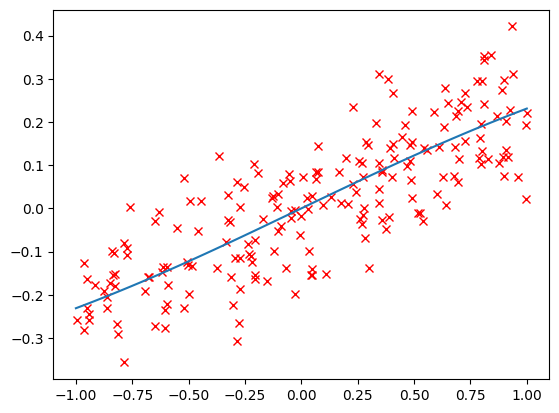

In [3]:
true_param_dict = {
    "W1": jnp.array([[0.5]]),
    "W2": jnp.array([[0.5]])
}
input_dim, num_hidden_nodes = true_param_dict["W1"].shape
output_dim = true_param_dict["W2"].shape[1]
num_training_samples = 200
one_layer_tanh = OneLayerTanhModel(
    true_param_dict, 
    num_training_samples=num_training_samples,
    input_dim=input_dim, 
    output_dim=output_dim,
    num_hidden_nodes=num_hidden_nodes,
    sigma=0.1, 
    itemp=1.0
)

plt.plot(one_layer_tanh.X, one_layer_tanh.Y, "rx");
a = np.linspace(-1, 1, num=50)[:, np.newaxis]
plt.plot(a, one_layer_tanh.regression_func(a, true_param_dict));

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:80: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|█████████████████████████████████████████████| 1300/1300 [00:02<00:00, 585.38it/s, 1 steps of size 4.30e-02. acc. prob=0.93]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'.

Expected log joint density: 37600.76
Expected nll 88.71
423.83853


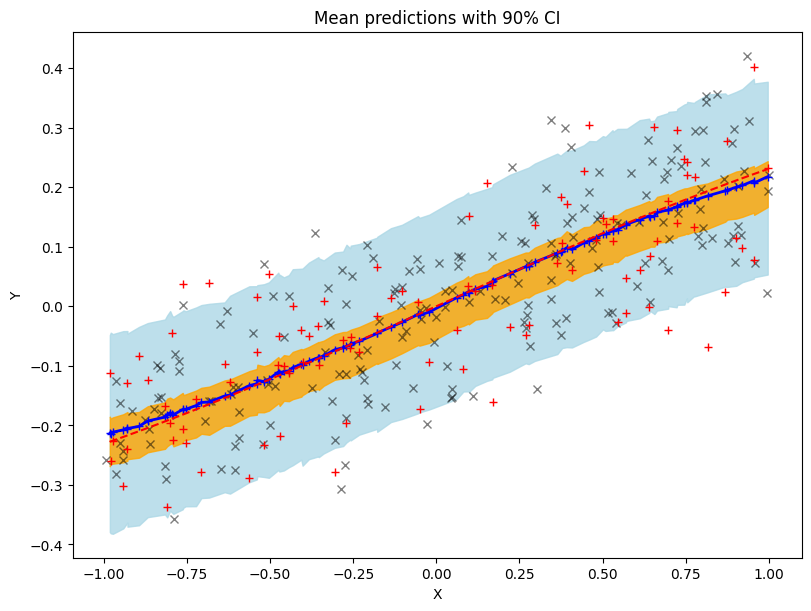

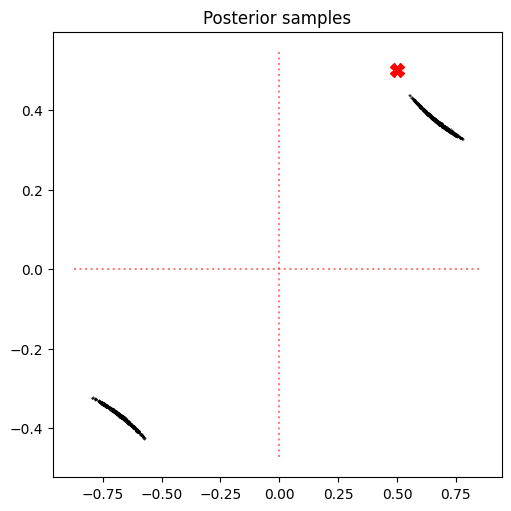

In [4]:
posterior_samples = one_layer_tanh.run_inference(
    num_warmup=300, 
    num_posterior_samples=1000, 
    num_chains=4,
    progress_bar=True, 
    itemp=1.0
)

X_test, Y_test = one_layer_tanh.generate_data(100)

sort_index = np.argsort(X_test[:, 0])
X_test = X_test[sort_index]
Y_test = Y_test[sort_index]

preds = one_layer_tanh.predict(posterior_samples, X_test)[..., 0] # shape = (posterior, test, )
mean_prediction = jnp.mean(preds, axis=0)
percentiles = np.percentile(preds, [5.0, 95.0], axis=0)
percentiles2 = np.percentile(preds, [30.0, 60.0], axis=0)


# make plots
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
# plot training data
ax.plot(one_layer_tanh.X, one_layer_tanh.Y, "kx", alpha=0.5)
# plot 90% confidence level of predictions
ax.fill_between(X_test[:, 0], percentiles[0, :], percentiles[1, :], color="lightblue", alpha=0.8)
ax.fill_between(X_test[:, 0], percentiles2[0, :], percentiles2[1, :], color="orange", alpha=0.8)

# plot mean prediction
ax.plot(X_test[:, 0], mean_prediction, color="blue", ls="solid", lw=2.0, marker="+")
ax.plot(X_test[:, 0], Y_test[:, 0], "r+")
ax.plot(X_test[:, 0], one_layer_tanh.regression_func(X_test, true_param_dict), "r--")
ax.set(xlabel="X", ylabel="Y", title="Mean predictions with 90% CI");


# a = np.linspace(-1, 1, num=50)[:, np.newaxis]
# ax.plot(a, one_layer_tanh.regression_func(a, true_param_dict), color="r")
# preds[0][0]

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)

i1, i2 = 0, 0
j1, j2 = 0, 0
ax.plot(posterior_samples["W1"][:, i1, i2], posterior_samples["W2"][:, j1, j2], "kx", markersize=1, alpha=0.5)
ax.plot([true_param_dict["W1"][i1, i2]], [true_param_dict["W2"][j1, j2]], "rX", markersize=10)

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()
ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
ax.set_title("Posterior samples");

pe = one_layer_tanh.mcmc.get_extra_fields()["potential_energy"]
nmpe = np.mean(-pe)
print(f'Expected log joint density: {nmpe:.2f}')

nlls = []
for i in range(one_layer_tanh.mcmc.num_samples * one_layer_tanh.mcmc.num_chains):
    param_dict = {name: param[i] for name, param in posterior_samples.items()}
    nlls.append(one_layer_tanh.expected_nll(param_dict))

enll = np.mean(nlls)
print(f"Expected nll {enll:.2f}")
print(nmpe / enll)

/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:80: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  self.mcmc = MCMC(
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 602.36it/s, 3 steps of size 6.06e-02. acc. prob=0.86]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'.

Finished itemp=0.13075918744449572. Expected NLL=88.75165557861328


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 603.44it/s, 5 steps of size 4.80e-02. acc. prob=0.89]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 887.26it/s, 75 steps of size 3.96e-02. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 887.17it/s, 35 steps of size 4.58e-02. acc. prob=0.89]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.14364362708299774. Expected NLL=88.7490005493164


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 616.51it/s, 1 steps of size 5.35e-02. acc. prob=0.82]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 671.62it/s, 47 steps of size 3.00e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1070.17it/s, 29 steps of size 5.00e-02. acc. prob=0.72]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.15652806672149977. Expected NLL=88.7435073852539


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 602.28it/s, 1 steps of size 5.91e-02. acc. prob=0.85]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 793.51it/s, 27 steps of size 3.13e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 983.78it/s, 43 steps of size 6.77e-02. acc. prob=0.89]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.16941250636000182. Expected NLL=88.74217224121094


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:02<00:00, 518.17it/s, 3 steps of size 3.48e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 849.48it/s, 69 steps of size 3.44e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 604.79it/s, 47 steps of size 2.59e-02. acc. prob=0.97]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.18229694599850382. Expected NLL=88.73954772949219


sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 555.36it/s, 11 steps of size 4.25e-02. acc. prob=0.93]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 778.11it/s, 43 steps of size 1.46e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 613.77it/s, 55 steps of size 2.84e-02. acc. prob=0.97]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.19518138563700588. Expected NLL=88.7369155883789


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:02<00:00, 501.77it/s, 3 steps of size 3.41e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 912.92it/s, 51 steps of size 2.50e-02. acc. prob=0.93]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 685.09it/s, 39 steps of size 4.88e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.2080658252755079. Expected NLL=88.73515319824219


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:02<00:00, 544.75it/s, 3 steps of size 3.27e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 842.71it/s, 87 steps of size 1.58e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 650.78it/s, 39 steps of size 3.96e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.22095026491400993. Expected NLL=88.7347183227539


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 585.76it/s, 3 steps of size 3.67e-02. acc. prob=0.91]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1034.36it/s, 23 steps of size 3.23e-02. acc. prob=0.89]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 624.01it/s, 47 steps of size 3.90e-02. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.23383470455251196. Expected NLL=88.73242950439453


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 560.75it/s, 3 steps of size 4.59e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 917.96it/s, 31 steps of size 4.46e-02. acc. prob=0.94]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 824.81it/s, 43 steps of size 2.69e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=0.24671914419101398. Expected NLL=88.73151397705078


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:02<00:00, 472.71it/s, 3 steps of size 9.72e-03. acc. prob=0.96]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|████████████████████████████████████████████| 1100/1100 [00:01<00:00, 700.50it/s, 55 steps of size 3.29e-02. acc. prob=0.95]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1069.73it/s, 43 steps of size 8.38e-02. acc. prob=0.89]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=1.0. Expected NLL=88.7146224975586


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 623.02it/s, 3 steps of size 1.04e-02. acc. prob=0.88]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1017.13it/s, 27 steps of size 1.56e-02. acc. prob=0.92]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1093.53it/s, 31 steps of size 4.94e-02. acc. prob=0.79]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=2.0. Expected NLL=88.71204376220703


sample: 100%|█████████████████████████████████████████████| 1100/1100 [00:01<00:00, 641.84it/s, 3 steps of size 7.46e-03. acc. prob=0.82]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 650.51it/s, 103 steps of size 4.72e-03. acc. prob=0.90]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:01<00:00, 1000.60it/s, 47 steps of size 1.67e-02. acc. prob=0.88]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=5.0. Expected NLL=88.71045684814453


sample: 100%|███████████████████████████████████████████| 1100/1100 [00:44<00:00, 24.93it/s, 1023 steps of size 6.65e-06. acc. prob=0.76]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:42<00:00, 26.15it/s, 1023 steps of size 1.29e-06. acc. prob=0.80]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipykernel_974/2414286604.py:87: UserWarning: Missing a plate statement for batch dimension -2 at site 'Y'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  self.mcmc.run(
sample: 100%|███████████████████████████████████████████| 1100/1100 [00:30<00:00, 35.82it/s, 1023 steps of size 8.60e-05. acc. prob=0.75]
/var/folders/fz/r7njsjl97v705mmmwpjrd6g80000gn/T/ipyke

Finished itemp=15.0. Expected NLL=88.71195220947266


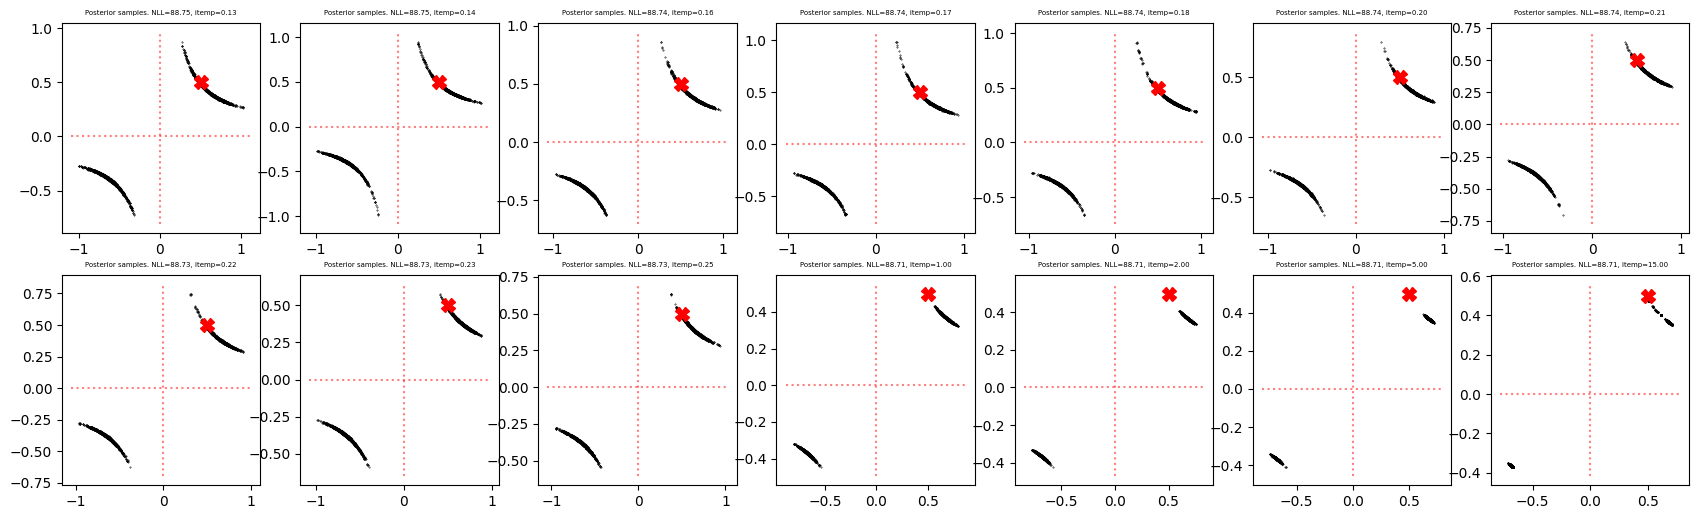

In [5]:
num_itemps = 10
n = one_layer_tanh.num_training_samples
itemps = np.linspace(
    1 / np.log(n) * (1 - 1 / np.sqrt(2 * np.log(n))),
    1 / np.log(n) * (1 + 1 / np.sqrt(2 * np.log(n))), 
    num_itemps
)

itemps = np.array(list(itemps) + [1.0, 2.0, 5.0, 15.0])

num_rows = 2
num_cols = len(itemps) // num_rows + (len(itemps) % num_rows != 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(3 * num_cols, 3 * num_rows))
axes = np.ravel(axes)
enlls = []
for i, itemp in enumerate(itemps):
    ax = axes[i]
    posterior_samples = one_layer_tanh.run_inference(
        num_warmup=100, 
        num_posterior_samples=1000,
        num_chains=4,
        progress_bar=True, 
        itemp=itemp
    )
    nlls = []
    for i in range(one_layer_tanh.mcmc.num_samples * one_layer_tanh.mcmc.num_chains):
        param_dict = {name: param[i] for name, param in posterior_samples.items()}
        nlls.append(one_layer_tanh.expected_nll(param_dict))

    enll = np.mean(nlls)
    enlls.append(enll)
    print(f"Finished itemp={itemp}. Expected NLL={enll}")
    
    i1, i2 = 0, 0
    j1, j2 = 0, 0
    ax.plot(posterior_samples["W1"][:, i1, i2], posterior_samples["W2"][:, j1, j2], "kx", markersize=1, alpha=0.5)
    ax.plot([true_param_dict["W1"][i1, i2]], [true_param_dict["W2"][j1, j2]], "rX", markersize=10)

    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    ax.hlines([0], xmin=xmin, xmax=xmax, linestyles="dotted", alpha=0.5, color='r')
    ax.vlines([0], ymin=ymin, ymax=ymax, linestyles="dotted", alpha=0.5, color='r')
    ax.set_title(f"Posterior samples. NLL={enll:.2f}, itemp={itemp:.2f}", fontdict={"fontsize": 5});


R^2=0.9966281733784291
R^2=0.9914308942800678
R^2=0.7478799150385964


Text(0, 0.5, 'Expected NLL')

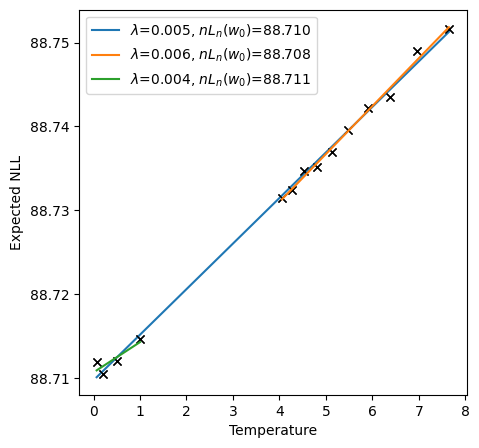

In [6]:
import scipy

fig, ax = plt.subplots(figsize=(5,5))


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps, enlls)
ax.plot(1/itemps, enlls, "kx")
ax.plot(1/itemps, 1/itemps * slope + intercept, label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}")
print(f"R^2={r_val**2}")


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[:num_itemps], enlls[:num_itemps])
ax.plot(1/itemps[:num_itemps], enlls[:num_itemps], "kx")
ax.plot(
    1/itemps[:num_itemps], 
    1/itemps[:num_itemps] * slope + intercept, 
    label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
)
print(f"R^2={r_val**2}")


slope, intercept, r_val, _, _ = scipy.stats.linregress(1 / itemps[num_itemps:], enlls[num_itemps:])
ax.plot(1/itemps[num_itemps:], enlls[num_itemps:], "kx")
ax.plot(
    1/itemps[num_itemps:], 
    1/itemps[num_itemps:] * slope + intercept, 
    label=f"$\lambda$={slope:.3f}, $nL_n(w_0)$={intercept:.3f}"
)
print(f"R^2={r_val**2}")

ax.legend()
ax.set_xlabel("Temperature")
ax.set_ylabel("Expected NLL")

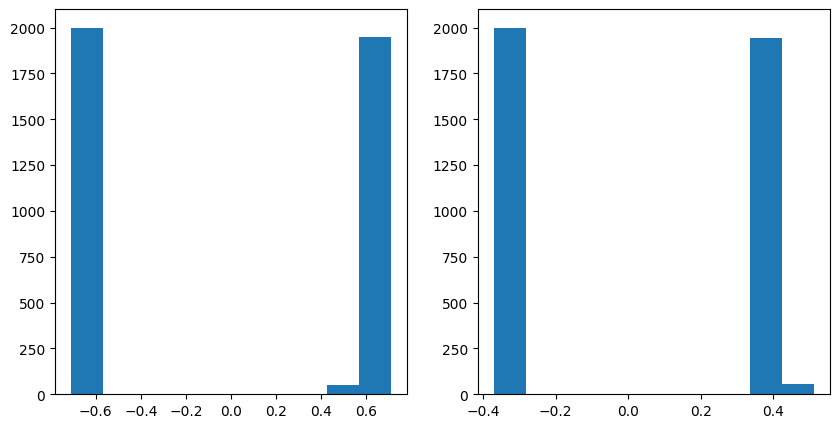

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]
ax.hist(posterior_samples["W1"][:, :, 0].flatten())
ax = axes[1]
ax.hist(posterior_samples["W2"][:, :, 0].flatten());